# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [22]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

# 新增年齡欄位(YEARS_BIRTH)
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / 365 # day-age to year-age

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

將年齡離散化後，對income做圖，了解各個年齡層的收入變化

In [19]:
# 將年齡資料離散化
#新增欄位 "bin_age", 對年齡做10組等寬劃分
bins = [20, 30, 40, 50, 60, 70]
app_train["bin_age"] = pd.cut(app_train["YEARS_BIRTH"], bins)
app_train["bin_age"].value_counts()

(30, 40]    82308
(40, 50]    76541
(50, 60]    68062
(20, 30]    45021
(60, 70]    35579
Name: bin_age, dtype: int64

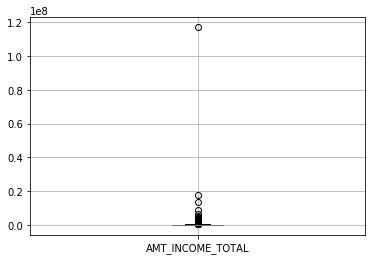

Outlier before replacement, the max income is: 117000000
Outlier after replacement, the max income is: 18000090


In [50]:
# 了解收入資料狀況，發現離群值資料(outlier)
app_train.boxplot(column='AMT_INCOME_TOTAL')
plt.show()
app_train['AMT_INCOME_TOTAL'].describe()

# 處理離群值資料(117000000以np.nan替補)
print("Outlier before replacement, the max income is: %i" % max(app_train['AMT_INCOME_TOTAL']))
app_train['AMT_INCOME_TOTAL'].replace({117000000:np.nan}, inplace=True)
print("Outlier after replacement, the max income is: %i" % max(app_train['AMT_INCOME_TOTAL']))

In [62]:
# 將年齡及income subset出來，並以describe簡單了解各組資料的資訊
app = app_train[['AMT_INCOME_TOTAL','bin_age']]
app.groupby('bin_age').describe()

AMT_INCOME_TOTAL                                                   \
                    count           mean            std      min       25%   
bin_age                                                                      
(20, 30]          45021.0  159520.624754   89176.415682  27000.0  112500.0   
(30, 40]          82307.0  177469.450699  112390.957384  27000.0  112500.0   
(40, 50]          76541.0  180565.509225  127346.085003  25650.0  112500.0   
(50, 60]          68062.0  165128.297171  103810.068421  25650.0  112500.0   
(60, 70]          35579.0  138897.496600   77767.362571  27000.0   90000.0   

                                          
               50%       75%         max  
bin_age                                   
(20, 30]  135000.0  184500.0   4500000.0  
(30, 40]  157500.0  225000.0  13500000.0  
(40, 50]  157500.0  225000.0  18000090.0  
(50, 60]  135000.0  202500.0   6750000.0  
(60, 70]  121500.0  171000.0   2250000.0

Text(0.5, 1.0, 'Amount of total income by Age Group')

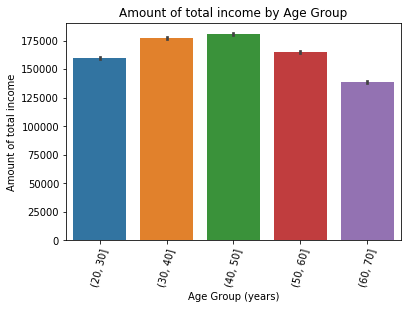

In [63]:
# 將離散化後的年齡與income作圖
px = app_train["bin_age"]
py = app_train["AMT_INCOME_TOTAL"]
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Amount of total income')
plt.title('Amount of total income by Age Group')

#可以看的出來，40-50歲區間的人之收入最高，其次為30-40歲區間的人